### 🩺 Classificação de Câncer de Mama com Machine Learning
### 👩‍💻 **Autora:** Thaís Cristina dos Santos 
---

### 🎯 Objetivo do Projeto
Este notebook tem como objetivo desenvolver um modelo de Machine Learning capaz de **prever se um tumor é benigno ou maligno** com base em características extraídas de imagens microscópicas de células.

A aplicação desse modelo pode apoiar médicos na tomada de decisão, trazendo uma segunda opinião rápida e confiável.

---

#### 📊 Dataset Utilizado
- **Nome:** Breast Cancer Wisconsin (Diagnostic)
- **Fonte:** Kaggle
- **Variável alvo:** Diagnóstico do tumor
  - `0` → Benigno  
  - `1` → Maligno

---

#### 🛠️ Tecnologias, bibliotecas e conceitos aplicados
- Python • Pandas • NumPy
- Visualização: Matplotlib / Seaborn
- Modelagem:
  - Train/Test Split
  - Padronização dos dados (StandardScaler)
  - Random Forest Classifier (ou ajuste conforme seu modelo)
- Métricas de avaliação:
  - Acurácia
  - Matriz de confusão
  - Classification Report
  - Curva ROC e AUC


### 🗂️ 1.Importação de Bibliotecas e Carregamento dos Dados
**Entender o dataset**:
   - Número de linhas e colunas.
   - Tipos de dados.
   - Presença de valores ausentes ou inconsistentes.

In [1]:
# 1) Importação de bibliotecas
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay
)

# Configurações visuais
%matplotlib inline
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (10,6)
RANDOM_STATE = 42


In [2]:
cancer_data= Path("data") / "cancer_data.csv"
cancer_data = pd.read_csv(cancer_data)
display( cancer_data)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


### 🧹2. Limpeza e Preparação de Dados
Vamos preparar o dataset para análise:
**Tratar valores ausentes**:
- Remover colunas irrelevantes (ex.: `id` ou `patient_id`).
- Converter target (`M`/`B`) para numérico.
- Converter colunas que parecem numéricas mas estão como string.
- Tratar valores ausentes ou incosistentes(se houver).


In [ ]:
# Cópia do dataset 
data = cancer_data.copy()

# Remover colunas 'id' ou 'Unnamed' comuns
cols_to_drop = [c for c in ['id', 'ID', 'patient_id'] if c in data.columns]
cols_to_drop += [c for c in data.columns if c.startswith('Unnamed')]
if cols_to_drop:
    data.drop(columns=cols_to_drop, inplace=True)
    print("Colunas removidas:", cols_to_drop)

# Se houver colunas numéricas como strings, convertê-las
for col in data.columns:
    if data[col].dtype == object and col != 'diagnosis':
        # tenta converter para numérico (coerce coloca NaN se falhar)
        data[col] = pd.to_numeric(data[col].str.replace(',','.'), errors='ignore')

# Criar variável alvo numérica (1 = Maligno, 0 = Benigno)
if 'diagnosis' in data.columns:
    # mapear apenas se valores conhecidos
    mapping = {'M': 1, 'B': 0, 'malignant': 1, 'benign': 0}
    if data['diagnosis'].dtype == object:
        data['diagnosis_num'] = data['diagnosis'].map(mapping)
    else:
        # se já for 0/1, renomeia
        data['diagnosis_num'] = data['diagnosis'].astype(int)

# Tratar NaNs nas colunas numéricas (ex.: preencher com média)
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
data[num_cols] = data[num_cols].apply(pd.to_numeric, errors='coerce')
nans = data[num_cols].isnull().sum()
if nans.sum() > 0:
    print("NaNs antes do preenchimento:\n", nans[nans>0])
    data[num_cols] = data[num_cols].fillna(data[num_cols].mean())
    print("NaNs preenchidos com a média das colunas.")

# Conferir resultado
print("\nDimensões após limpeza:", data.shape)
display(data.head())


Colunas removidas: ['id', 'Unnamed: 32']

Dimensões após limpeza: (569, 32)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_num
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [17]:
# Valores nulos
print("Nulos por coluna:")
print(cancer_data.isnull().sum()[cancer_data.isnull().sum() > 0])

# Colunas não numéricas
non_numeric = cancer_data.select_dtypes(exclude=[np.number]).columns.tolist()
print("\nColunas não numéricas:", non_numeric)

# Verifica valores únicos na coluna alvo (se existir)
if 'diagnosis' in cancer_data.columns:
    print("\nContagem por classe (diagnosis):")
    print(cancer_data['diagnosis'].value_counts())


Nulos por coluna:
Unnamed: 32    569
dtype: int64

Colunas não numéricas: ['diagnosis']

Contagem por classe (diagnosis):
diagnosis
B    357
M    212
Name: count, dtype: int64


#### 🔍3. Análise Exploratória
- Distribuições das features principais
- Boxplots por classe
- Correlação entre features


,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


Top 6 features por variância: ['area_worst', 'area_mean', 'area_se', 'perimeter_worst', 'perimeter_mean', 'texture_worst']


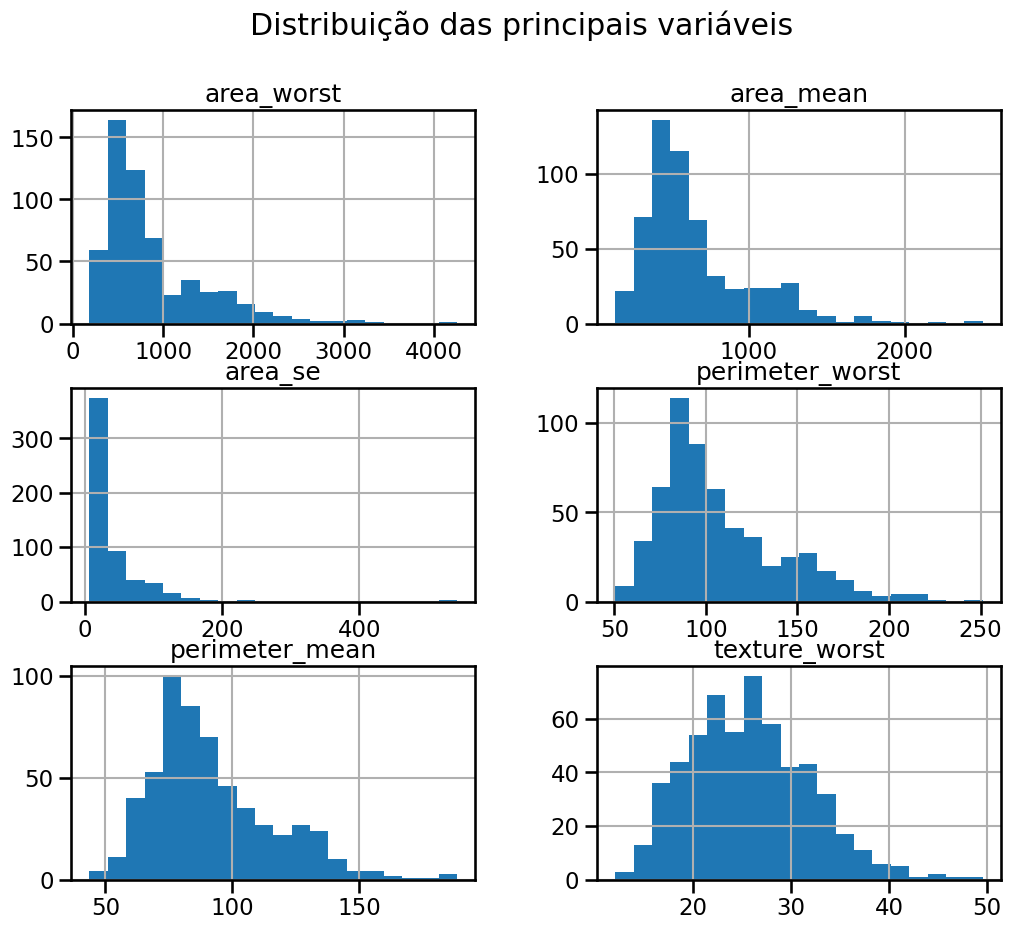

In [ ]:
# Estatísticas descritivas
display(data.describe().T)

# Histogramas de algumas features selecionadas (os nomes dependem do dataset)
sample_feats = data.select_dtypes(include=[np.number]).columns.tolist()
# se existir diagnosis_num, removemos para histogramas gerais
if 'diagnosis_num' in sample_feats:
    sample_feats.remove('diagnosis_num')

# Top 6 por variação para plotar 
variances = data[sample_feats].var().sort_values(ascending=False)
top6 = variances.index[:6].tolist()
print("Top 6 features por variância:", top6)

# Histogramas
data[top6].hist(bins=20, layout=(3,2), figsize=(12,10))
plt.suptitle("Distribuição das principais variáveis")
plt.show()


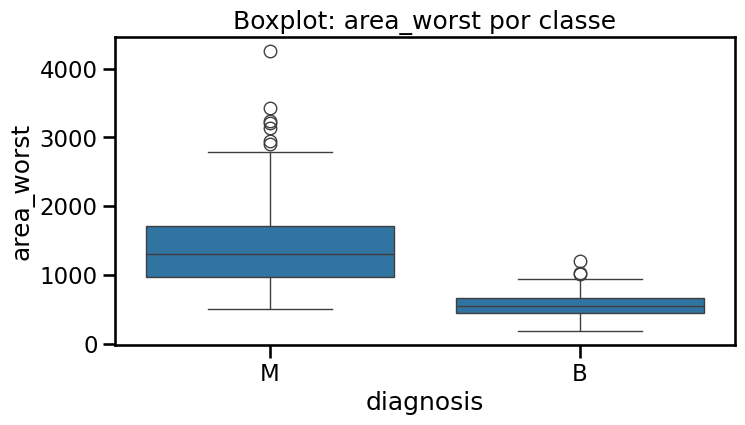

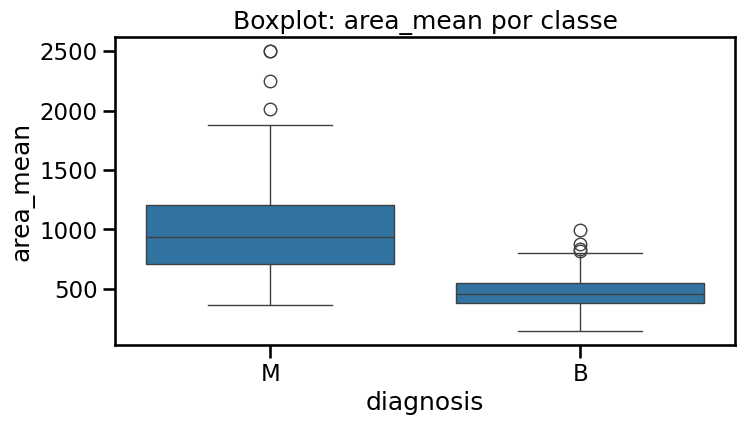

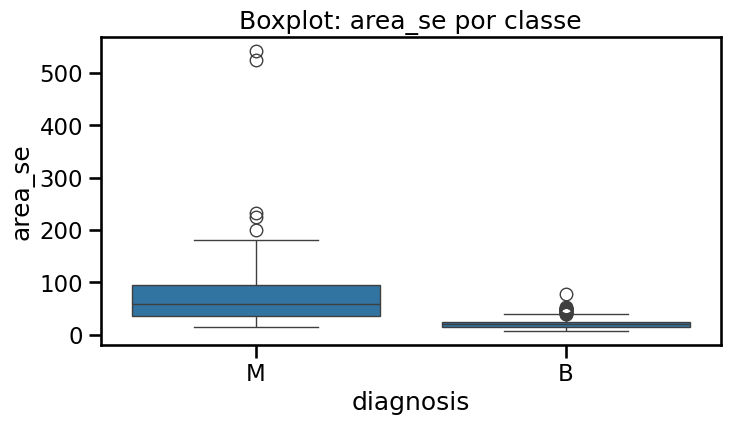

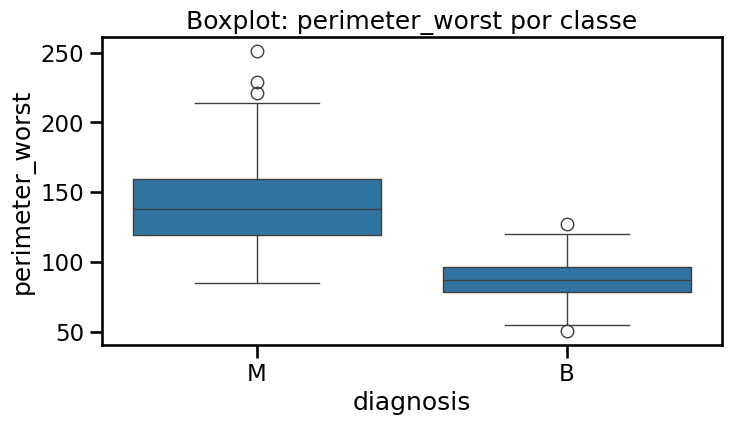

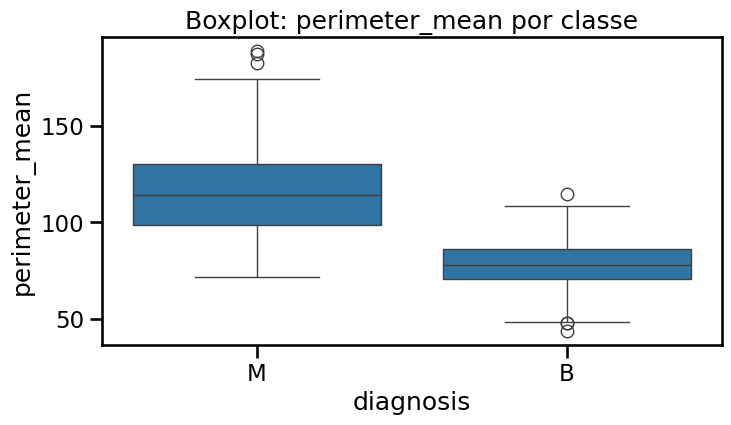

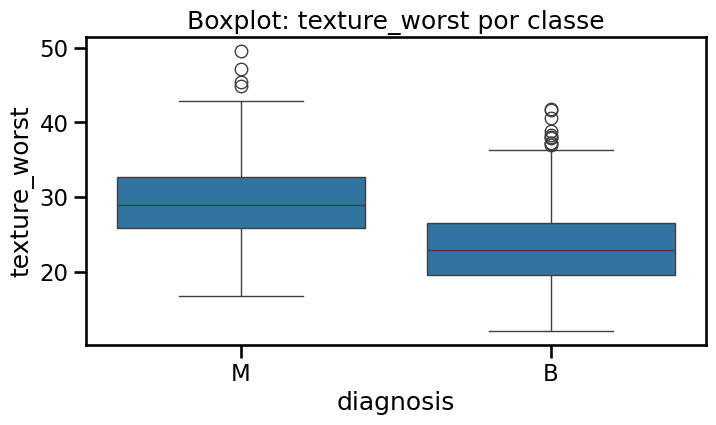

In [6]:
# Boxplots comparando benigno vs maligno para top6
if 'diagnosis' in data.columns or 'diagnosis_num' in data.columns:
    target_col = 'diagnosis' if 'diagnosis' in data.columns else 'diagnosis_num'
    for feat in top6:
        plt.figure(figsize=(8,4))
        sns.boxplot(x='diagnosis' if 'diagnosis' in data.columns else 'diagnosis_num', y=feat, data=data)
        plt.title(f"Boxplot: {feat} por classe")
        plt.show()


Coluna alvo detectada: 'diagnosis'
📌 Top 5 variáveis com maior correlação (valor e sinal):

 - concave points_worst: 0.7936 (signo +)
 - perimeter_worst: 0.7829 (signo +)
 - concave points_mean: 0.7766 (signo +)
 - radius_worst: 0.7765 (signo +)
 - perimeter_mean: 0.7426 (signo +)


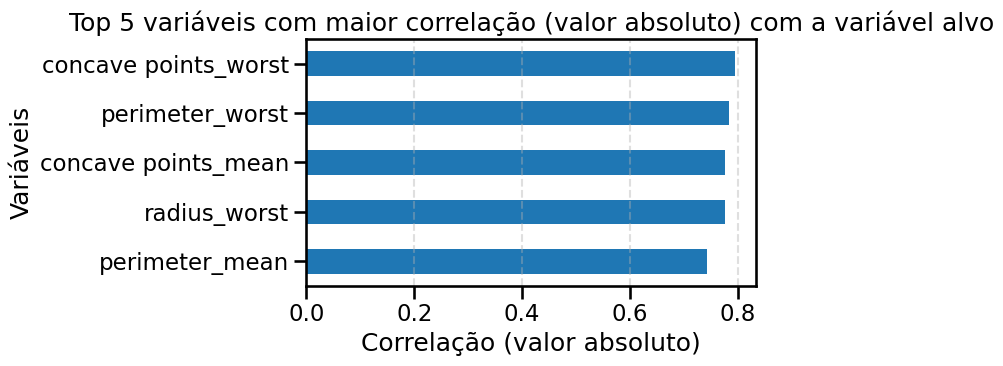

In [ ]:
# ------------------------------------------------------------
# Correlação das variáveis com a variável alvo 
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# usar o dataframe
df = cancer_data.copy()

# 1) Detectar coluna alvo 
possible_names = ['alvo', 'target', 'diagnosis', 'diagnóstico', 'diagnostico', 'diagnostic', 'label']
target_col = None
for name in possible_names:
    if name in df.columns:
        target_col = name
        break

# 2) Se não encontrou pelo nome, procura coluna com valores tipo 'M'/'B' ou 'malignant'/'benign'
if target_col is None:
    for col in df.columns:
        if df[col].dtype == object or pd.api.types.is_categorical_dtype(df[col]):
            unique_vals = set(map(lambda x: str(x).strip().lower(), df[col].dropna().unique()))
            if unique_vals <= {'m', 'b'} or unique_vals <= {'malignant', 'benign'} or unique_vals <= {'maligno','benigno'}:
                target_col = col
                break

if target_col is None:
    raise ValueError("Não foi possível detectar automaticamente a coluna alvo. "
                     "Por favor, passe a célula com o dataframe e nome da coluna alvo (ex.: 'alvo' ou 'diagnosis').")

print(f"Coluna alvo detectada: '{target_col}'")

# 3) Mapear valores textuais para numéricos (se necessário)
if not pd.api.types.is_numeric_dtype(df[target_col]):
    # mapa com variantes em lower()
    mapping_lower = {
        'm': 1, 'malignant': 1, 'maligno': 1,
        'b': 0, 'benign': 0, 'benigno': 0,
        '1': 1, '0': 0
    }
    df[target_col] = df[target_col].apply(lambda x: mapping_lower.get(str(x).strip().lower(), x))

# tentar converter para numérico (se ainda não for)
if not pd.api.types.is_numeric_dtype(df[target_col]):
    try:
        df[target_col] = pd.to_numeric(df[target_col])
    except Exception as e:
        raise ValueError(f"Não foi possível converter a coluna alvo para numérico: {e}")

# 4) Selecionar apenas colunas numéricas para calcular correlação
numeric_df = df.select_dtypes(include=[np.number]).copy()

# garantir que a coluna alvo esteja entre as numéricas (caso a conversão tenha falhado)
if target_col not in numeric_df.columns:
    numeric_df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

# 5) Calcular correlação com a variável alvo (Pearson)
correlations = numeric_df.corr()[target_col].drop(labels=[target_col], errors='ignore')

# 6) Selecionar as TOP 5 (maior valor absoluto)
top5_abs = correlations.abs().sort_values(ascending=False).head(5)
top5 = correlations.loc[top5_abs.index]  # preserva sinal

# 7) Exibir os resultados de forma clara
print("📌 Top 5 variáveis com maior correlação (valor e sinal):\n")
for var, corr in top5.items():
    print(f" - {var}: {corr:.4f} (signo {'+' if corr>=0 else '-'})")

# 8) Gráfico horizontal com valor absoluto para fácil visualização
plt.figure(figsize=(8,4))
(top5.abs().sort_values()).plot(kind='barh')
plt.title("Top 5 variáveis com maior correlação (valor absoluto) com a variável alvo")
plt.xlabel("Correlação (valor absoluto)")
plt.ylabel("Variáveis")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


#### 🔧 4. Pré-processamento dos dados

Nesta etapa, realizamos:
- Separação entre variáveis preditoras (`X`) e variável alvo (`y`)
- Divisão do conjunto em dados de treino e teste
- Padronização das variáveis com `StandardScaler`

A padronização é importante porque muitos algoritmos de ML são sensíveis à escala das variáveis.



In [8]:
# Definir X e y
if 'diagnosis_num' in data.columns:
    target = 'diagnosis_num'
elif 'diagnosis' in data.columns:
    target = 'diagnosis'  # caso não tenha transformado, mas ideal já ter numérico
else:
    raise ValueError("Coluna alvo não encontrada. Certifique-se que existe 'diagnosis' ou 'diagnosis_num'.")

X = data.drop(columns=[c for c in [target, 'diagnosis'] if c in data.columns])  # remove target(s) text/num
y = data[target]

# Se X tiver colunas não numéricas (sobra), seleciona só numéricas
X = X.select_dtypes(include=[np.number])

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("Distribuição (treino):\n", y_train.value_counts(normalize=True))
print("Distribuição (teste):\n", y_test.value_counts(normalize=True))


Shapes: (455, 30) (114, 30) (455,) (114,)
Distribuição (treino):
 diagnosis_num
0    0.626374
1    0.373626
Name: proportion, dtype: float64
Distribuição (teste):
 diagnosis_num
0    0.631579
1    0.368421
Name: proportion, dtype: float64


#### 🤖 5. Treinamento dos modelos de Machine Learning

Neste projeto, treinamos **dois modelos de classificação** para comparar desempenho:

| Modelo | Vantagens |
|--------|----------|
| **Regressão Logística** | Simples, rápido e interpretável |
| **Random Forest Classifier** | Alta performance e robustez contra overfitting |

O pipeline aplicado inclui:
- Padronização dos dados com `StandardScaler`
- Treinamento dos modelos com dados de treino (`X_train`, `y_train`)
- Avaliação dos modelos com dados de teste (`X_test`, `y_test`)


In [9]:
# Pipeline - Regressão Logística
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]

print("Regressão Logística - Relatório")
print(classification_report(y_test, y_pred_lr, digits=4))
print("AUC:", roc_auc_score(y_test, y_proba_lr))


Regressão Logística - Relatório
              precision    recall  f1-score   support

           0     0.9595    0.9861    0.9726        72
           1     0.9750    0.9286    0.9512        42

    accuracy                         0.9649       114
   macro avg     0.9672    0.9573    0.9619       114
weighted avg     0.9652    0.9649    0.9647       114

AUC: 0.996031746031746


In [10]:
# Random Forest com busca de parâmetros (GridSearch simples)
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 6, 10],
    'min_samples_split': [2, 5]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("Melhor params RandomForest:", gs.best_params_)
best_rf = gs.best_estimator_

# Previsões
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

print("\nRandom Forest - Relatório")
print(classification_report(y_test, y_pred_rf, digits=4))
print("AUC:", roc_auc_score(y_test, y_proba_rf))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhor params RandomForest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest - Relatório
              precision    recall  f1-score   support

           0     0.9600    1.0000    0.9796        72
           1     1.0000    0.9286    0.9630        42

    accuracy                         0.9737       114
   macro avg     0.9800    0.9643    0.9713       114
weighted avg     0.9747    0.9737    0.9735       114

AUC: 0.9928902116402116


#### 📊 6. Comparação entre os modelos

Ambos os modelos apresentaram bons resultados, porém com diferenças importantes:

- A **Regressão Logística** tende a ser mais interpretável e rápida para treinar.
- A **Random Forest** geralmente apresenta desempenho superior pois captura relações mais complexas entre as variáveis.

Para aplicações na área médica, além da acurácia, damos mais atenção ao **Recall para a classe Maligna**, pois minimizar falsos negativos é crucial.


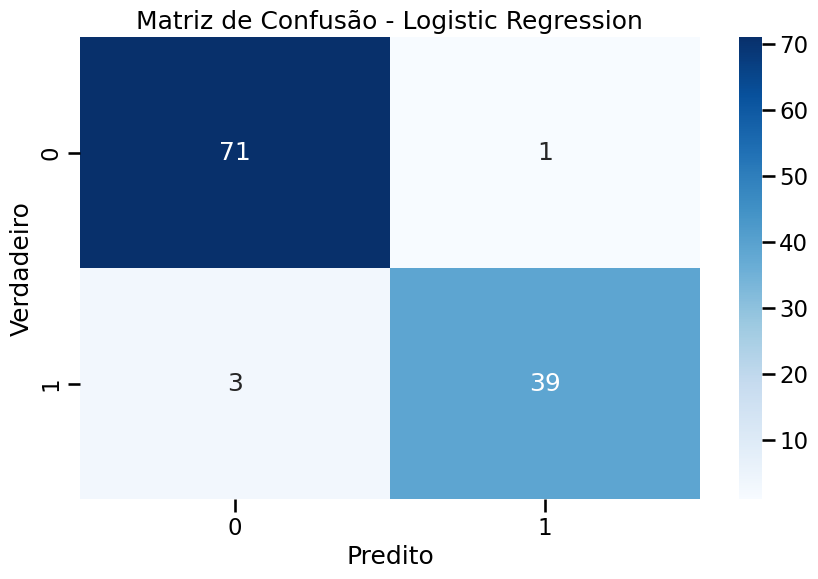

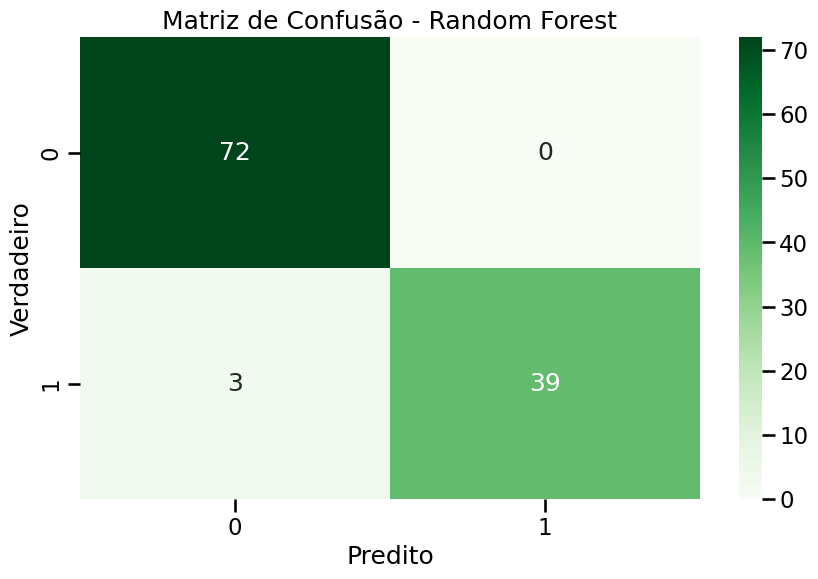

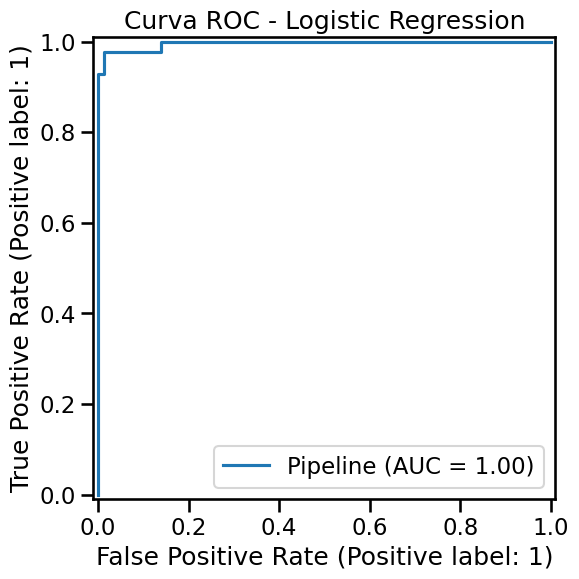

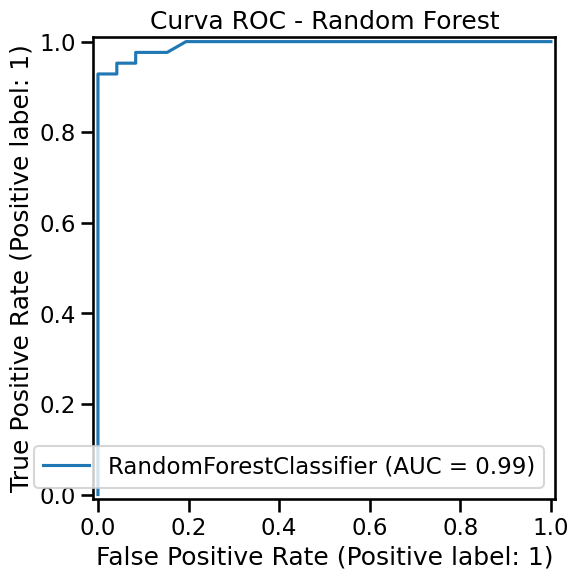

In [11]:
# Matriz de confusão - Logistic
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Logistic Regression")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

# Matriz de confusão - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

# ROC curves
RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test)
plt.title("Curva ROC - Logistic Regression")
plt.show()

RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Curva ROC - Random Forest")
plt.show()


#### 🧠 Interpretando a Matriz de Confusão

- **Verdadeiro Positivo (VP):** Modelo identificou tumor maligno corretamente
- **Verdadeiro Negativo (VN):** Modelo identificou tumor benigno corretamente
- **Falso Positivo (FP):** Modelo indicou maligno quando era benigno
- **Falso Negativo (FN):** Modelo indicou benigno quando era maligno (⚠️ crítico em diagnóstico clínico)

O foco é **reduzir o número de FNs**, pois impactam diretamente o diagnóstico.


#### 📈 Curva ROC e Métrica AUC

A métrica AUC indica a capacidade do modelo em separar as classes:
- **AUC = 1.0** → Separação perfeita
- **AUC = 0.5** → Aleatório (péssimo)


#### 🔍 7. Importância de variáveis

- Para Random Forest: feature_importances_
- Para Regressão: coeficientes (após escala)


area_worst              0.151412
concave points_worst    0.126497
radius_worst            0.093475
perimeter_worst         0.083642
concave points_mean     0.081082
perimeter_mean          0.077126
radius_mean             0.061990
concavity_mean          0.050818
area_mean               0.045916
concavity_worst         0.030022
area_se                 0.029064
compactness_worst       0.018005
texture_worst           0.016174
texture_mean            0.015545
smoothness_worst        0.015093
radius_se               0.014503
symmetry_worst          0.013301
compactness_mean        0.012218
perimeter_se            0.012037
fractal_dimension_se    0.006592
dtype: float64

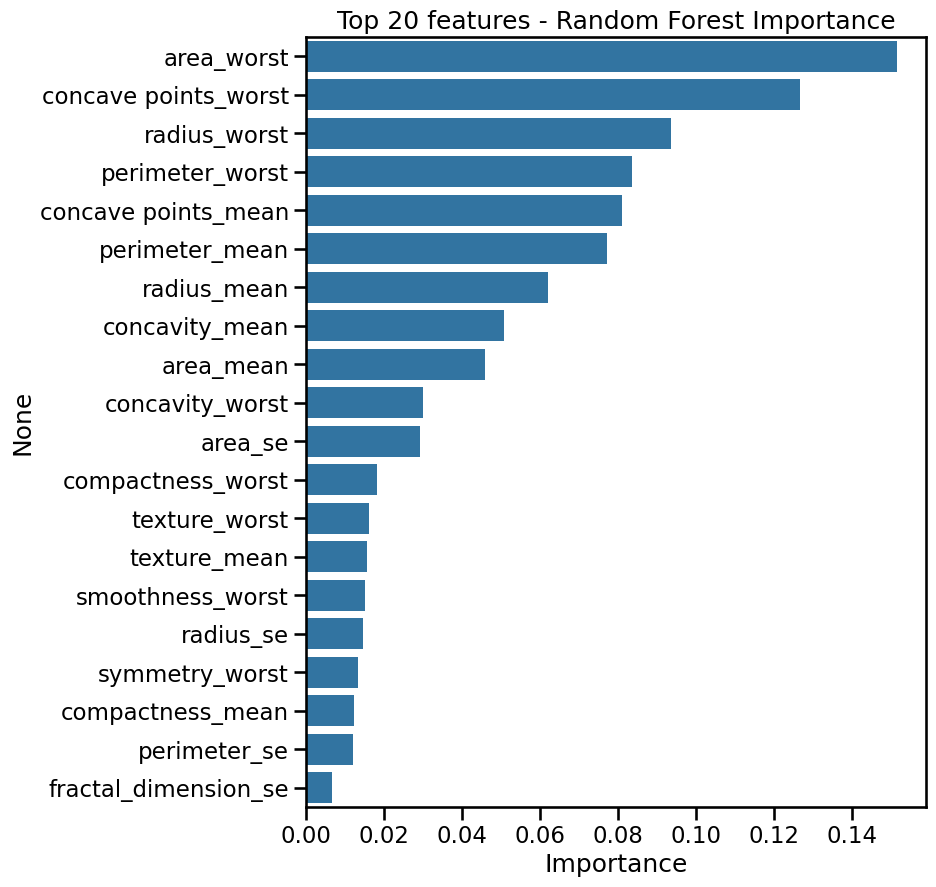

In [12]:
# Importância do Random Forest
feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)
display(feat_importances.head(20))

plt.figure(figsize=(8,10))
sns.barplot(x=feat_importances.values[:20], y=feat_importances.index[:20])
plt.title("Top 20 features - Random Forest Importance")
plt.xlabel("Importance")
plt.show()


In [13]:
# Coeficientes da Regressão (após scaler) - extras
# Obter pipeline: scaler + lr
scaler = pipe_lr.named_steps['scaler']
lr = pipe_lr.named_steps['lr']
coefs = lr.coef_[0]
# como os coeficientes são em escala padronizada, listá-los
coef_df = pd.Series(coefs, index=X.columns).sort_values(key=abs, ascending=False)
display(coef_df.head(20))


texture_worst           1.434093
radius_se               1.233325
symmetry_worst          1.061264
concave points_mean     0.952813
concavity_worst         0.911406
area_se                 0.909029
compactness_se         -0.906925
area_worst              0.900477
radius_worst            0.896968
concavity_mean          0.782298
perimeter_se            0.748295
perimeter_worst         0.723111
concave points_worst    0.703999
fractal_dimension_se   -0.593876
texture_mean            0.482219
concave points_se       0.482089
area_mean               0.439950
compactness_mean       -0.439546
smoothness_worst        0.420207
texture_se             -0.407611
dtype: float64

#### 8. Validação cruzada 
- Cross-val AUC para comparar estabilidade dos modelos.


In [14]:
# Cross-val AUC (pipeline para rf precisa de pipeline com scaler? RF nao precisa, mas vamos usar pipeline padrão)
from sklearn.pipeline import make_pipeline

pipe_rf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=RANDOM_STATE, **gs.best_params_))
scores_lr = cross_val_score(pipe_lr, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
scores_rf = cross_val_score(pipe_rf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)

print("CV AUC - Logistic:", scores_lr.mean(), "±", scores_lr.std())
print("CV AUC - RandomForest:", scores_rf.mean(), "±", scores_rf.std())


CV AUC - Logistic: 0.9953143278274297 ± 0.005345297368904428
CV AUC - RandomForest: 0.9884823259106751 ± 0.008222190718257187


#### 9. Salvar modelo
- Salvar o melhor modelo para uso posterior.


In [15]:
import joblib
joblib.dump(best_rf, "rf_best_model.pkl")
joblib.dump(pipe_lr, "pipe_lr_model.pkl")
print("Modelos salvos: rf_best_model.pkl, pipe_lr_model.pkl")


Modelos salvos: rf_best_model.pkl, pipe_lr_model.pkl


#### 🏁 Conclusão

Os dois modelos treinados obtiveram ótimo desempenho na classificação de tumores (benignos vs malignos).  
No entanto, o modelo **Random Forest apresentou o melhor equilíbrio entre acurácia e recall para tumores malignos**, tornando-se o mais adequado para este problema.

Além disso:
- A análise de correlação ajudou a identificar as características mais importantes do diagnóstico.
- A padronização foi essencial para o bom desempenho da Regressão Logística.

O projeto demonstra como Machine Learning pode ser utilizado como ferramenta de apoio à tomada de decisão na área da saúde.
